# import imprortant library


In [29]:
import pandas as pd
import numpy as np
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import cv2.cuda
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from PIL import Image
from keras.utils import to_categorical
import torch
import warnings
warnings.filterwarnings('ignore')
import torchvision.models as models
from keras.utils import to_categorical
from sklearn.model_selection import KFold 
from sklearn import model_selection
from sklearn.model_selection import train_test_split
import torch.nn as nn
from typing import Any, List
import torchvision
from torch import optim , autocast
import torch.nn as nn
from torch.utils.data import Dataset
import torch.nn.functional as F
import cv2
from torch.cuda.amp import GradScaler
from torchvision import transforms, datasets
from collections import Counter
from torch.optim import AdamW
from sklearn.metrics import confusion_matrix
from torchvision.models import googlenet
from efficientnet_pytorch import EfficientNet
import optuna
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# load dataset


In [30]:
wafer_tensors = torch.load('wafer_tensors.pt')
label_wm = torch.load('label_wm.pt')

In [31]:
print("Wafer Tensors Shape:", wafer_tensors.shape)
print("Label Tensors Shape:", label_wm.shape)

Wafer Tensors Shape: torch.Size([368568, 3, 56, 56])
Label Tensors Shape: torch.Size([368568, 1, 36])


In [32]:
args = {"BATCH_SIZE": 512, "LEARNING_RATE": 5e-4, "NUM_EPOCH": 100}

In [33]:
USE_CUDA = torch.cuda.is_available()
DEVICE = "cuda" if USE_CUDA else "cpu"

In [34]:
torch.cuda.device_count()

1

In [35]:
import torch.utils.data as data


class BasicDataset(data.Dataset):
    def __init__(self, x_tensor, y_tensor):
        super(BasicDataset, self).__init__()

        self.x = x_tensor
        self.y = y_tensor

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)

In [36]:
train_X, test_X, train_Y, test_Y = model_selection.train_test_split(
    wafer_tensors, label_wm, test_size=0.2, random_state= 42
)
train_X, val_X, train_Y, val_Y = model_selection.train_test_split(
    train_X, train_Y, test_size=0.2, random_state=42
)
dataset_train = BasicDataset(train_X, train_Y)
dataset_val = BasicDataset(val_X, val_Y)
dataset_test = BasicDataset(test_X, test_Y)
dataset = ConcatDataset([dataset_train, dataset_val])

In [37]:
class GoogLeNet(nn.Module):
    def __init__(self, num_classes=36):
        super(GoogLeNet, self).__init__()
        self.googlenet = models.googlenet(pretrained=True)
        self.googlenet.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.googlenet(x)
        return x

In [38]:
GoogleNet = GoogLeNet().to(DEVICE)

In [39]:
def train_epoch(model, dataloader, loss_fn, optimizer,scaler, batch_size):
    train_loss, train_correct = 0.0, 0
    model.train()
    for images, labels in dataloader:
        images, labels = images.to(DEVICE), labels.to(DEVICE).reshape(
            batch_size, 36
        )
        optimizer.zero_grad()
        with autocast(device_type=DEVICE):
            output = model(images)
            labels = torch.argmax(labels, dim=1)
            loss = loss_fn(output, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        train_loss += loss.item() * images.size(0)
        predictions = torch.argmax(output, 1)
        train_correct += (predictions == labels).sum().item()
        scaler.update()
    
    return train_loss, train_correct


def valid_epoch(model, dataloader, loss_fn,batch_size):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    for images, labels in dataloader:
        images, labels = images.to(DEVICE), labels.to(DEVICE).reshape(
            batch_size, 36
        )
        output = model(images)
        labels = torch.argmax(labels, dim=1)
        loss = loss_fn(output, labels)
        valid_loss += loss.item() * images.size(0)
        predictions = torch.argmax(output, 1)
        val_correct += (predictions == labels).sum().item()
    return valid_loss, val_correct

In [40]:
def objective(trial):
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64,128, 256, 512])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
    num_epochs = trial.suggest_int('num_epochs', 10, 100)
    momentum = trial.suggest_uniform('momentum', 0.0, 1.0)
    patience = trial.suggest_int('patience', 5, 20)
    num_epochs_cond = trial.suggest_int('num_epochs_cond', 10, 100)
    accuracies = []
    model = GoogLeNet().to(DEVICE)
    criterion = torch.nn.CrossEntropyLoss().to(DEVICE)  # 비용 함수에 소프트맥스 함수 포함되어져 있음.
    optimizer = optim.SGD(
        model.parameters(), lr=learning_rate, momentum=momentum)
    torch.manual_seed(42)
    
    train_loader = DataLoader(
        dataset_train, batch_size=batch_size, shuffle=True, drop_last=True
    )
    test_loader = DataLoader(
        dataset_val, batch_size=batch_size, shuffle=True, drop_last=True
    )
    
    history = {"train_loss": [], "test_loss": [], "train_acc": [], "test_acc": []}
    # Initialize variables for early stopping
    best_loss = np.inf
    counter = 0
    
    scaler = GradScaler()
    
    for epoch in range(num_epochs):
        train_loss, train_correct = train_epoch(
            model, train_loader, criterion, optimizer, scaler,batch_size
        )
        
        test_loss, test_correct = valid_epoch(model, test_loader, criterion,batch_size)
        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        test_loss = test_loss / len(test_loader.sampler)
        test_acc = test_correct / len(test_loader.sampler) * 100
        accuracies.append(test_acc)
        
        
        if epoch >= num_epochs_cond:
            
            if test_loss < best_loss:
                best_loss = test_loss
                counter = 0
            else:
                counter += 1
                
            if counter >= patience:
                print(
                    "Validation loss has not improved for {} epochs. Stopping training...".format(
                        patience
                    )
                )
                break
                
        print(
            "Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(
                epoch + 1, num_epochs, train_loss, test_loss, train_acc, test_acc
            )
        )

    
    avg_accuracy = np.mean(accuracies)
    return avg_accuracy

In [41]:
# Create an Optuna study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Get the best hyperparameters and objective value
best_params = study.best_params
best_value = study.best_value

print("Best hyperparameters:", best_params)
print("Best average accuracy:", best_value)

[I 2023-11-04 08:47:18,902] A new study created in memory with name: no-name-a80bbb52-2c8c-44e5-ad20-1dd3533a77b6


Epoch:1/92 AVG Training Loss:3.017 AVG Test Loss:2.413 AVG Training Acc 21.63 % AVG Test Acc 35.51 %
Epoch:2/92 AVG Training Loss:2.027 AVG Test Loss:1.664 AVG Training Acc 40.53 % AVG Test Acc 47.48 %
Epoch:3/92 AVG Training Loss:1.482 AVG Test Loss:1.287 AVG Training Acc 50.11 % AVG Test Acc 55.18 %
Epoch:4/92 AVG Training Loss:1.189 AVG Test Loss:1.058 AVG Training Acc 57.07 % AVG Test Acc 61.52 %
Epoch:5/92 AVG Training Loss:0.993 AVG Test Loss:0.895 AVG Training Acc 62.82 % AVG Test Acc 66.45 %
Epoch:6/92 AVG Training Loss:0.854 AVG Test Loss:0.796 AVG Training Acc 67.31 % AVG Test Acc 69.34 %
Epoch:7/92 AVG Training Loss:0.755 AVG Test Loss:0.699 AVG Training Acc 71.02 % AVG Test Acc 73.45 %
Epoch:8/92 AVG Training Loss:0.681 AVG Test Loss:0.647 AVG Training Acc 73.93 % AVG Test Acc 75.19 %
Epoch:9/92 AVG Training Loss:0.621 AVG Test Loss:0.587 AVG Training Acc 76.43 % AVG Test Acc 77.52 %
Epoch:10/92 AVG Training Loss:0.574 AVG Test Loss:0.582 AVG Training Acc 78.26 % AVG Test A

[I 2023-11-04 09:38:05,121] Trial 0 finished with value: 87.95972301787246 and parameters: {'batch_size': 512, 'learning_rate': 0.000582923442761474, 'num_epochs': 92, 'momentum': 0.7328342140527289, 'patience': 19, 'num_epochs_cond': 21}. Best is trial 0 with value: 87.95972301787246.


Epoch:92/92 AVG Training Loss:0.053 AVG Test Loss:0.213 AVG Training Acc 98.39 % AVG Test Acc 93.30 %
Epoch:1/31 AVG Training Loss:2.224 AVG Test Loss:1.293 AVG Training Acc 36.79 % AVG Test Acc 55.05 %
Epoch:2/31 AVG Training Loss:1.073 AVG Test Loss:0.820 AVG Training Acc 59.93 % AVG Test Acc 67.58 %
Epoch:3/31 AVG Training Loss:0.774 AVG Test Loss:0.639 AVG Training Acc 69.51 % AVG Test Acc 75.00 %
Epoch:4/31 AVG Training Loss:0.632 AVG Test Loss:0.537 AVG Training Acc 75.63 % AVG Test Acc 79.25 %
Epoch:5/31 AVG Training Loss:0.535 AVG Test Loss:0.457 AVG Training Acc 79.85 % AVG Test Acc 82.64 %
Epoch:6/31 AVG Training Loss:0.468 AVG Test Loss:0.404 AVG Training Acc 82.66 % AVG Test Acc 84.89 %
Epoch:7/31 AVG Training Loss:0.417 AVG Test Loss:0.364 AVG Training Acc 84.83 % AVG Test Acc 86.47 %
Epoch:8/31 AVG Training Loss:0.376 AVG Test Loss:0.333 AVG Training Acc 86.35 % AVG Test Acc 87.65 %
Epoch:9/31 AVG Training Loss:0.342 AVG Test Loss:0.309 AVG Training Acc 87.79 % AVG Test A

[I 2023-11-04 10:12:44,753] Trial 1 finished with value: 88.51414664725856 and parameters: {'batch_size': 128, 'learning_rate': 0.001071523598366277, 'num_epochs': 31, 'momentum': 0.28092263500434644, 'patience': 18, 'num_epochs_cond': 25}. Best is trial 1 with value: 88.51414664725856.


Epoch:31/31 AVG Training Loss:0.110 AVG Test Loss:0.183 AVG Training Acc 96.28 % AVG Test Acc 93.81 %
Epoch:1/68 AVG Training Loss:1.505 AVG Test Loss:0.613 AVG Training Acc 51.20 % AVG Test Acc 77.20 %
Epoch:2/68 AVG Training Loss:0.688 AVG Test Loss:0.387 AVG Training Acc 75.34 % AVG Test Acc 85.97 %
Epoch:3/68 AVG Training Loss:0.489 AVG Test Loss:0.300 AVG Training Acc 82.99 % AVG Test Acc 89.53 %
Epoch:4/68 AVG Training Loss:0.386 AVG Test Loss:0.247 AVG Training Acc 86.80 % AVG Test Acc 91.34 %
Epoch:5/68 AVG Training Loss:0.328 AVG Test Loss:0.215 AVG Training Acc 88.95 % AVG Test Acc 92.60 %
Epoch:6/68 AVG Training Loss:0.283 AVG Test Loss:0.199 AVG Training Acc 90.52 % AVG Test Acc 93.20 %
Epoch:7/68 AVG Training Loss:0.253 AVG Test Loss:0.183 AVG Training Acc 91.57 % AVG Test Acc 93.76 %
Epoch:8/68 AVG Training Loss:0.228 AVG Test Loss:0.176 AVG Training Acc 92.46 % AVG Test Acc 94.09 %
Epoch:9/68 AVG Training Loss:0.208 AVG Test Loss:0.167 AVG Training Acc 93.13 % AVG Test A

[I 2023-11-04 16:01:18,822] Trial 2 finished with value: 94.66627861625325 and parameters: {'batch_size': 16, 'learning_rate': 0.00012990240139308724, 'num_epochs': 68, 'momentum': 0.8154420810562775, 'patience': 20, 'num_epochs_cond': 15}. Best is trial 2 with value: 94.66627861625325.


Validation loss has not improved for 20 epochs. Stopping training...
Epoch:1/88 AVG Training Loss:1.919 AVG Test Loss:1.010 AVG Training Acc 42.32 % AVG Test Acc 62.43 %
Epoch:2/88 AVG Training Loss:0.880 AVG Test Loss:0.623 AVG Training Acc 67.08 % AVG Test Acc 76.25 %
Epoch:3/88 AVG Training Loss:0.632 AVG Test Loss:0.479 AVG Training Acc 76.63 % AVG Test Acc 82.12 %
Epoch:4/88 AVG Training Loss:0.505 AVG Test Loss:0.388 AVG Training Acc 81.68 % AVG Test Acc 85.73 %
Epoch:5/88 AVG Training Loss:0.424 AVG Test Loss:0.332 AVG Training Acc 84.87 % AVG Test Acc 88.00 %
Epoch:6/88 AVG Training Loss:0.367 AVG Test Loss:0.294 AVG Training Acc 87.11 % AVG Test Acc 89.59 %
Epoch:7/88 AVG Training Loss:0.326 AVG Test Loss:0.273 AVG Training Acc 88.59 % AVG Test Acc 90.24 %
Epoch:8/88 AVG Training Loss:0.295 AVG Test Loss:0.249 AVG Training Acc 89.79 % AVG Test Acc 91.16 %
Epoch:9/88 AVG Training Loss:0.269 AVG Test Loss:0.231 AVG Training Acc 90.68 % AVG Test Acc 91.86 %
Epoch:10/88 AVG Traini

[W 2023-11-04 17:00:44,082] Trial 3 failed with parameters: {'batch_size': 64, 'learning_rate': 0.0008132265826319166, 'num_epochs': 88, 'momentum': 0.3032558395358764, 'patience': 8, 'num_epochs_cond': 86} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\envs\new_-\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\husse\AppData\Local\Temp\ipykernel_4960\3215103457.py", line 30, in objective
    train_loss, train_correct = train_epoch(
  File "C:\Users\husse\AppData\Local\Temp\ipykernel_4960\222647683.py", line 13, in train_epoch
    scaler.scale(loss).backward()
  File "c:\ProgramData\anaconda3\envs\new_-\lib\site-packages\torch\_tensor.py", line 492, in backward
    torch.autograd.backward(
  File "c:\ProgramData\anaconda3\envs\new_-\lib\site-packages\torch\autograd\__init__.py", line 251, in backward
    Variable._execution_engine.run_backwar

KeyboardInterrupt: 

In [24]:
testl_f, tl_f, testa_f, ta_f = [], [], [], []
k = 5
for f in range(1, k + 1):
    tl_f.append(np.mean(foldperf["fold{}".format(f)]["train_loss"]))
    testl_f.append(np.mean(foldperf["fold{}".format(f)]["test_loss"]))

    ta_f.append(np.mean(foldperf["fold{}".format(f)]["train_acc"]))
    testa_f.append(np.mean(foldperf["fold{}".format(f)]["test_acc"]))

print("Performance of {} fold cross validation".format(k))
print(
    "Average Training Loss: {:.3f} \t Average Test Loss: {:.3f} \t Average Training Acc: {:.2f} \t Average Test Acc: {:.2f}".format(
        np.mean(tl_f), np.mean(testl_f), np.mean(ta_f), np.mean(testa_f)
    )
)

Performance of 5 fold cross validation
Average Training Loss: 0.016 	 Average Test Loss: 0.047 	 Average Training Acc: 99.29 	 Average Test Acc: 97.70


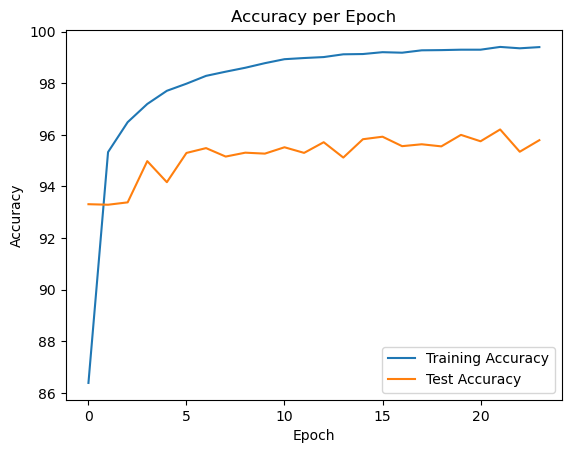

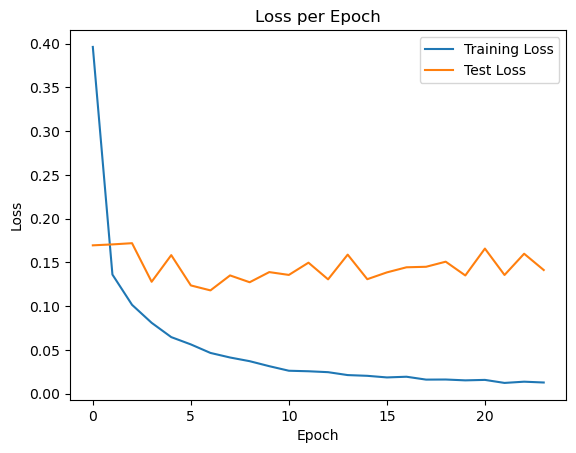

In [25]:
history = foldperf["fold1"]

# Plot training and test accuracy
plt.plot(history["train_acc"], label="Training Accuracy")
plt.plot(history["test_acc"], label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()
plt.show()

# Plot training and test loss
plt.plot(history["train_loss"], label="Training Loss")
plt.plot(history["test_loss"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()
plt.show()

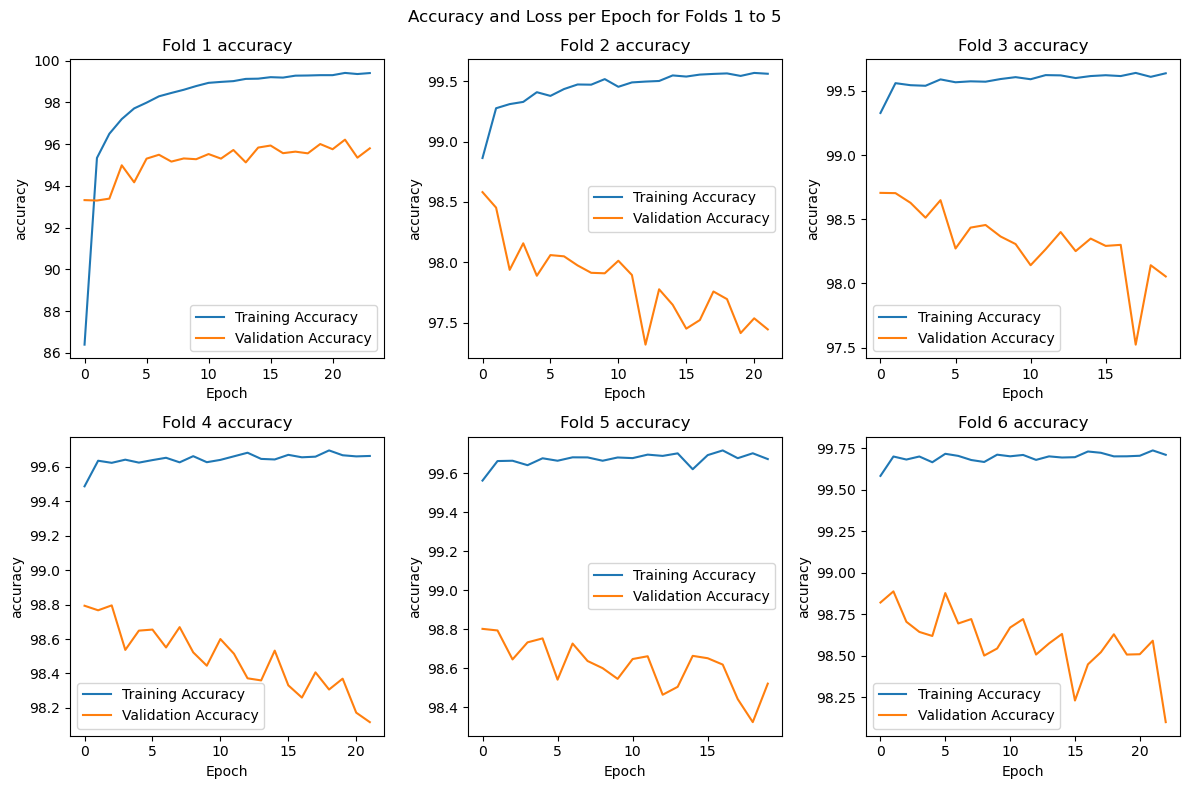

In [28]:
# Determine the number of folds
num_folds = 6  # You can change this to match the actual number of folds

# Create a grid of subplots for each metric (accuracy and loss)
num_rows = 2
num_cols = (num_folds + 1) // 2  # Calculate the number of columns needed based on the number of folds
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
fig.suptitle("Accuracy and Loss per Epoch for Folds 1 to 5")



for fold_number in range(1, num_folds + 1):
    history = foldperf[f"fold{fold_number}"]

    # Calculate the subplot position
    row = (fold_number - 1) // num_cols  # Row number (0 or 1)
    col = (fold_number - 1) % num_cols  # Column number (0 or 1)

    # Plot training and test loss
    axes[row, col].plot(history["train_acc"], label="Training Accuracy")
    axes[row, col].plot(history["test_acc"], label="Validation Accuracy")
    axes[row, col].set_xlabel("Epoch")
    axes[row, col].set_ylabel("accuracy")
    axes[row, col].set_title(f"Fold {fold_number} accuracy")
    axes[row, col].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
print(history)

In [ ]:
torch.save(GoogleNet.state_dict(), 'model.pth')

In [ ]:
torch.save(wafer_tensors, 'wafer_tensors.pt')

In [ ]:
torch.save(label_wm, 'label_wm.pt')

In [ ]:
torch.save(test_X, 'test_X.pt')
torch.save(test_Y, 'test_Y.pt')